In [101]:
# Title: Contact models for atomic force microscopy
# Author: J. P. S. Ferreira
# Date: 2023-01-17
# Description: This notebook is a draft for a work on contact models for atomic force microscopy. It is a work in progress.
# Literature: 
# (1) https://www.sciencedirect.com/science/article/pii/S0968432822000245 
# (2) https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3010-3
# License: MIT

In [102]:
# Math and Dataframes
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import PercentFormatter

# Machine Learning 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
import torch
from torch import nn
# from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# import verstack
# from verstack.stratified_continuous_split import scsplit

# Others
from datetime import datetime
import os
from pathlib import Path
import csv
import pickle



In [103]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

# update to latex fonts
plt.rcParams.update(tex_fonts)

## Hertz and JKR functions

In [104]:
def hertz(i, E, nu, r):
    """Hertz model for indentation.
    
    approximation for parabolic indenter.
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    R : float
        Radius of the indenter/probing tip.
        
    Returns
    -------
    float
        Contact force.
    """
    # 'a' and 'factor' calculated based on ref (2)
    # search for other formulas to obtain these parameters
    a = i/r
    factor = 1 - 0.1 * a - (1/840) * a**2 + (11/15120) * a**3 + (1357/6652800) * a**4
    force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

# Johnson-Kendall-Roberts model for indentation
# (3) https://lizidelcidphd.com/2017/07/07/the-simplified-johnson-kendall-roberts-model/
def jkr(i, E, nu, gamma, r):
    """Johnson-Kendall-Roberts model for indentation.
    
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    gamma : float
        Surface energy.
    R : float
        Radius of the indenter.
        
    Returns
    -------
    float
        Contact force.
    """
    # JKR force formula in (3)
    force = E * r **0.5 * i**1.5 - gamma * E**0.5 * r**0.75 * i**0.75
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

## Parameter definition

In [105]:
# resolution of the map
res = 60
# random values
size = res * res
# Young's modulus [kPa] - random values following a normal distribution
    #loc: mean/center of distribution
    #scale: std
E = abs(np.random.normal(loc=1.0, scale=0.3, size=size))
# Poisson's ratio 
nu = 0.5
# surface energy
    #gamma in (3) is given in J sub-units(???), but gamma <> Ua
gamma = abs(np.random.normal(loc=10.0, scale=3.0, size=size))
# gamma = 0.1
# radius of the indenter
r = 1.0

(array([  8.,   6.,  34.,  48.,  87., 181., 292., 318., 430., 452., 470.,
        420., 321., 218., 144.,  91.,  44.,  24.,  10.,   2.]),
 array([ 0.35111266,  1.32862182,  2.30613098,  3.28364014,  4.26114931,
         5.23865847,  6.21616763,  7.19367679,  8.17118595,  9.14869512,
        10.12620428, 11.10371344, 12.0812226 , 13.05873176, 14.03624092,
        15.01375009, 15.99125925, 16.96876841, 17.94627757, 18.92378673,
        19.90129589]),
 <BarContainer object of 20 artists>)

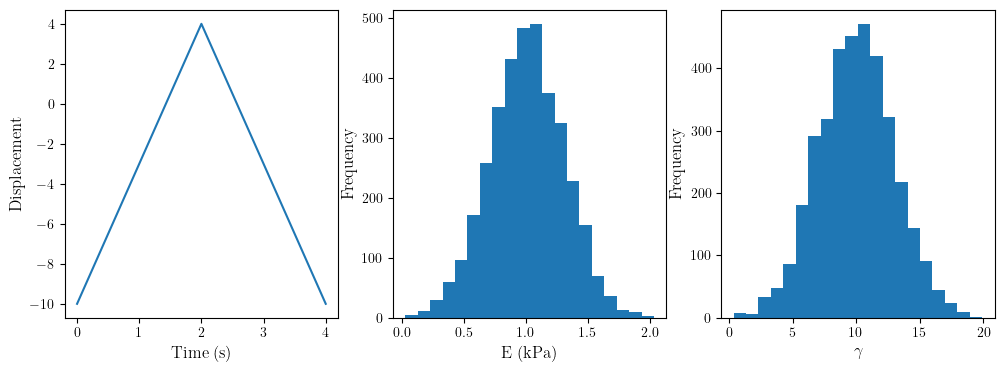

In [106]:
# no contact approach. less points
#linspace(p1, p2, n_pts)
no_contact = np.linspace(-10, 0, 3)

'''DISPLACEMENT VECTORS'''
xmin, xmax, npts = 0, 4, 20

'''Uniformly distributed disp. vectors'''
# indentation depth. more points
contact = np.linspace(xmin, xmax, npts)
# approach and withdraw
approach = np.concatenate([no_contact[:-1], contact])
withdraw = np.flip(approach)
ramp = np.concatenate([approach, withdraw])

'''Randomly distributed disp. vectors'''
rnd_contact_list = [contact]
for _ in range(size-1):
    aux = np.random.random(npts).cumsum()
    aux = (aux-aux.min()) / aux.ptp()     #... .ptp(): peak to peak, i.e., xmax-xmin
    aux = (xmax-xmin)*aux + xmin
    rnd_contact_list.append(aux)
rnd_contact = np.array(rnd_contact_list)
rnd_approach = np.concatenate([np.repeat([no_contact[:-1]], size, axis=0), rnd_contact], axis=1)
rnd_withdraw = np.flip(rnd_approach, axis=1)

# define ramp time
half_cycle = 2 
t_approach = half_cycle*((approach - approach.min(axis=0)) / (approach.max(axis=0) - approach.min(axis=0)))
t_withdraw = half_cycle*((withdraw - withdraw.max(axis=0)) / (withdraw.min(axis=0) - withdraw.max(axis=0)))+max(t_approach)
t = np.concatenate([t_approach, t_withdraw])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Displacement')
ax1.plot(t, ramp)
ax2.set_xlabel('E (kPa)')
ax2.set_ylabel('Frequency')
ax2.hist(E, 20)
ax3.set_xlabel('$\gamma$')
ax3.set_ylabel('Frequency')
ax3.hist(gamma, 20)

## Initial df

In [107]:
# construct dataframe
df = pd.DataFrame()
# 'E' and 'gamma' arrays to list:
df['E'] = E.tolist()
df['gamma'] = gamma.tolist()
# assigns the displacement array for each 'E' (num of E values = len(df) = size)
df['approach'] = [rnd_approach[app] for app in range(len(df))]
df['withdraw'] = [rnd_withdraw[wd] for wd in range(len(df))]
# '..._interp' columns have the sole purpose of allowing the sns errorbar plot 
df['approach_interp'] = [approach for _ in range(len(df))]
df['withdraw_interp'] = [withdraw for _ in range(len(df))]
# applies hertz and jkr models to each row (axis= 0(col) or 1(row))
    # x will take the values of each row 
df['f_hertz'] = df.apply(lambda x: hertz(x.approach, x.E, nu, r), axis=1)
df['f_jkr'] = df.apply(lambda x: jkr(x.withdraw, x.E, nu, x.gamma, r), axis=1)
df['f_hertz_interp'] = df.apply(lambda x: np.interp(x.approach_interp, x.approach, x.f_hertz), axis=1)
df['f_jkr_interp'] = df.apply(lambda x: np.interp(-x.withdraw_interp, -x.withdraw, x.f_jkr), axis=1)


C:\Users\luisr\AppData\Local\Temp\ipykernel_11604\2075678178.py:25: RuntimeWarning: invalid value encountered in power
  force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
C:\Users\luisr\AppData\Local\Temp\ipykernel_11604\2075678178.py:54: RuntimeWarning: invalid value encountered in power
  force = E * r **0.5 * i**1.5 - gamma * E**0.5 * r**0.75 * i**0.75


## Initial df - plots

(4.7, -10.7, -58.774881069713764, 23.402761431502213)

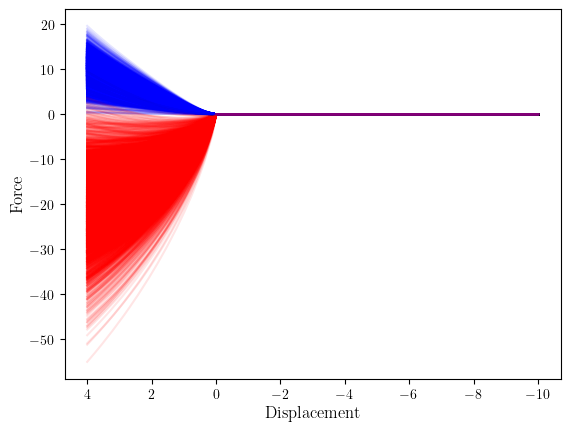

In [108]:
# plot all entries naively
# i: row index; row: data of each row in series format
for i, row in df.iterrows():
    #alpha: transparency
    plt.plot(row['approach'], row['f_hertz'], color='blue', alpha=0.1)
    plt.plot(row['withdraw'], row['f_jkr'], color='red', alpha=0.1)
#add labels
plt.xlabel('Displacement')
plt.ylabel('Force')
# invert x axis
# plt.axis() returns (xmin, xmax, ymin, ymax)
ax = plt.axis()
plt.axis((ax[1],ax[0],ax[2],ax[3]))

C:\Users\luisr\AppData\Local\Temp\ipykernel_11604\2536315331.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df2, x='approach_interp', y='f_hertz_interp', palette='Set1', errorbar='sd', color='blue')
C:\Users\luisr\AppData\Local\Temp\ipykernel_11604\2536315331.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df2, x='withdraw_interp', y='f_jkr_interp',  palette='Set2', errorbar='sd', color = 'orange')


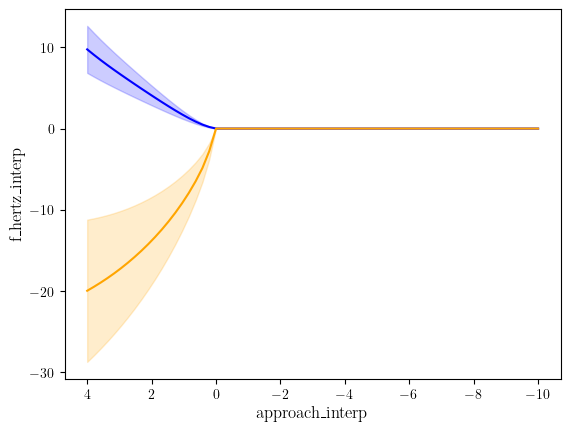

In [109]:
# plot all entries with seaborn
    # set_index: sets 'E' as the index (so the right value of E is assigned to the correct rows after the explode)
    # Series.explode: 'explodes' the arrays (disp and force) into different rows (scalars in each cell instead of arrays)
    # reset_index: because E is no longer needed as an index
df2 = df.set_index(['E', 'gamma']).apply(pd.Series.explode).reset_index()
ax = sns.lineplot(data=df2, x='approach_interp', y='f_hertz_interp', palette='Set1', errorbar='sd', color='blue')
ax = sns.lineplot(data=df2, x='withdraw_interp', y='f_jkr_interp',  palette='Set2', errorbar='sd', color = 'orange')
ax.invert_xaxis()

## Initial df - Mapping E

<AxesSubplot: >

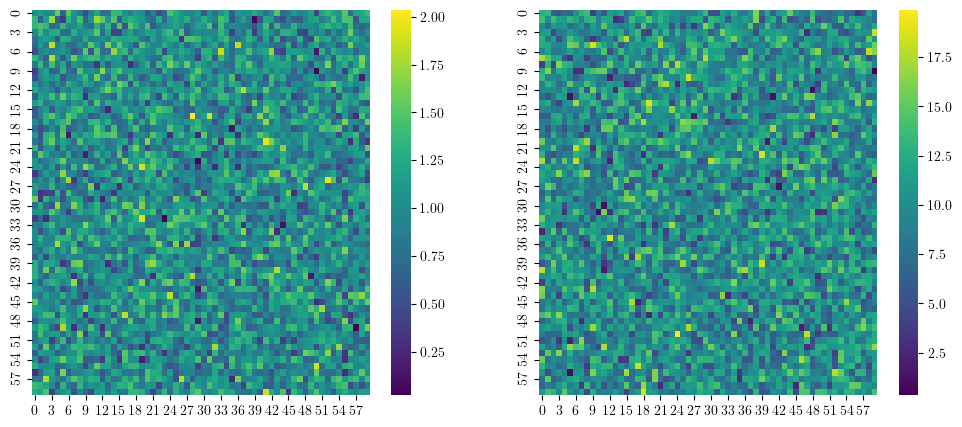

In [110]:
# map random values to a 2D array
#transforms E from array to matrix
E_map = np.reshape(E, (res, res))
gamma_map = np.reshape(gamma, (res, res))
# Young's modulus and surface energy random maps
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(E_map, cmap='viridis', ax=axes[0])
sns.heatmap(gamma_map, cmap='viridis', ax=axes[1])
#NOTE: examples at https://seaborn.pydata.org/examples/index.html

<AxesSubplot: >

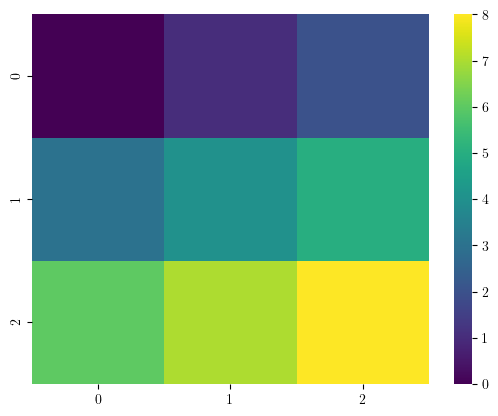

In [111]:
#check reshape rule.
# create sequential integers array of size 9
v = np.arange(0, 9, 1, dtype=int)
# reshape to 3x3
vmap = np.reshape(v, (3, 3))
# print array
sns.heatmap(vmap, cmap='viridis')
#NOTE: reshape rule is row-major, i.e. the first index is the row index. The second index is the column index.

# **HERTZ**

In [112]:
#dataframe with contact-only data
#df_hc: hertz contact
df_hc = pd.DataFrame()
df_hc['approach_contact'] = df['approach'].apply(lambda x: x[x>=0])
df_hc['f_hertz_contact'] = df['f_hertz'].apply(lambda x: x[len(no_contact)-1:])
df_hc['E_hertz'] = df['E']
#df_hc['appproach_contact'] = df.apply(lambda x: x.approach[x.approach>=0], axis=1)
#check size of disp and force vectors
print(df_hc['approach_contact'][0].shape, df_hc['f_hertz_contact'][0].shape)

(20,) (20,)


### Inputs and labels

In [113]:
x_hc = np.array(df_hc[['approach_contact', 'f_hertz_contact']])
y_hc = np.array(df_hc['E_hertz'])
print(x_hc.shape, y_hc.shape)

(3600, 2) (3600,)


### Splitting with train_test_split()

((2520, 2),
 (540, 2),
 (540, 2),
 (2520,),
 array([[array([0.        , 0.28484524, 0.52540445, 0.82008439, 1.1368067 ,
                1.16526871, 1.34905411, 1.5643556 , 1.90412793, 2.06763444,
                2.13989915, 2.38998464, 2.49872268, 2.88837691, 3.17317424,
                3.40899041, 3.4513264 , 3.52465463, 3.84908219, 4.        ]),
         array([ 0.        ,  0.27322375,  0.66741579,  1.26087349,  1.98722605,
                 2.05579078,  2.50868513,  3.05755556,  3.95195192,  4.39106922,
                 4.58654962,  5.26887824,  5.56827008,  6.65656697,  7.47319914,
                 8.17034288,  8.2981272 ,  8.52168087,  9.55212614, 10.06044449])],
        [array([0.        , 0.16635141, 0.35436442, 0.63049836, 0.83731287,
                1.14228396, 1.25948831, 1.51538725, 1.77048103, 2.02522018,
                2.33957292, 2.42716232, 2.5458692 , 2.77683928, 3.09089215,
                3.24409619, 3.45448265, 3.75355982, 3.8571234 , 4.        ]),
         array([ 

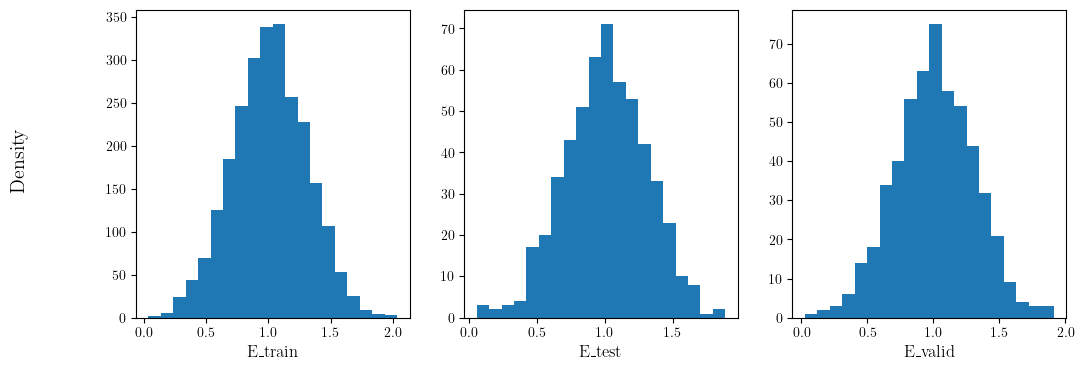

In [114]:
test_ratio = 0.15
# (!!!) validation ratio is currently given in relation to the entire dataset (!!!!)
valid_ratio = 0.15 
rnd_state = 42

# Without stratify
#x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio, random_state=rnd_state)

#With stratify
bin_count = 50
bins = pd.qcut(y_hc, bin_count, labels=False, duplicates='drop')
x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio,
                                                     random_state=rnd_state, stratify = bins)

bins = pd.qcut(y_train, bin_count, labels=False, duplicates='drop')
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_ratio/(1-test_ratio),
                                                       random_state=rnd_state, stratify = bins)

# Create list of nested arrays [np.array(features), np.array(labels)] to later be saved as pkl for each train
dataset = [x_train, y_train, x_valid, y_valid, x_test, y_test]



fig, ax = plt.subplots(1,3, figsize=(12,4))
dens = True
xlabel_list_hertz = ['E_train', 'E_test', 'E_valid']
if dens:
    fig.supylabel('Density')
else:
    fig.supylabel('Frequency')
for ix, sp in enumerate(ax):
    sp.set_xlabel(xlabel_list_hertz[ix])
ax[0].hist(y_train, 20)
ax[1].hist(y_test, 20)
ax[2].hist(y_valid, 20)

x_train.shape, x_valid.shape, x_test.shape, y_train.shape, x_train

## ML

In [115]:
# Training and test data from np arrays to torch tensor with desired shape
def tensor_input_shape(nparray):
    '''
    Input: nparray - numpy array with two dimensions (n_samples, n_features)
    Output: torch_tensor - pytorch tensor with 3 dimensions (n_samples, n_pts, n_features) 
    '''
    n_samples = len(nparray)
    n_pts = len(nparray[0,0])
    torch_tensor = torch.zeros(size=(n_samples, n_pts, 2))
    for i in range(n_samples):
        aux_nparray = np.hstack((nparray[i,0].reshape((n_pts,1)), nparray[i,1].reshape((n_pts,1))))
        aux_ttensor = torch.from_numpy(aux_nparray).type(torch.float)
        torch_tensor[i,:,:] = aux_ttensor
    return torch_tensor

x_train_t = tensor_input_shape(x_train)
x_valid_t = tensor_input_shape(x_valid)
x_test_t = tensor_input_shape(x_test)
y_train_t = torch.from_numpy(y_train).type(torch.float).unsqueeze(dim=1)
y_valid_t = torch.from_numpy(y_valid).type(torch.float).unsqueeze(dim=1)
y_test_t = torch.from_numpy(y_test).type(torch.float).unsqueeze(dim=1)
#x_train_t2 = torch.from_numpy(x_train).type(torch.float)

x_train_t.shape, y_train_t.shape


(torch.Size([2520, 20, 2]), torch.Size([2520, 1]))

In [116]:
def create_model_dir(timestamp, contact_model: str):

  ''' Second input must be 'hertz' or 'jkr' '''
  
  allowed_models = ['hertz', 'jkr']
  if contact_model not in allowed_models:
    raise ValueError("Input value must be one of %s" % allowed_models)
  model_path = 'model_{}'.format(timestamp)
  parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese'
  if contact_model == 'hertz':
    dir = 'Hertz_models'
  elif contact_model == 'jkr':
    dir = 'JKR_models'
  path = os.path.join(parent_dir, dir, model_path)
  # path = os.path.join(initial_wd, dir, model_path)
  os.mkdir(path)
  os.chdir(path)

def data_as_pkl(dataset_list: list):
  file_names = ['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test']
  new_dir = 'Train_Validation_Data'
  current_path = os.getcwd()
  os.mkdir(new_dir)
  os.chdir(new_dir)
  for i, array in enumerate(dataset_list):
    with open(file_names[i]+'.pkl', 'wb') as f:
      pickle.dump(array, f)
  os.chdir(current_path)

def plot_loss_curve(epochs, mse_training, mse_validation, loss: bool):
  plt.figure()
  plt.xlabel("Epoch")
  if loss:
    plt.ylabel("Loss")
    plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  else:
    plt.ylabel("Error (\%)")
    plt.plot(epochs[0:], mse_training[0:], label="Training Error")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Error")    
  plt.legend()  
  # We're not going to plot the first epoch (>>greater loss)
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  top_of_y_axis = highest_loss + (delta * 0.2)
  bottom_of_y_axis = lowest_loss - (delta * 0.2)   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  if loss:
    plt.savefig('loss_plot.pdf') 
  else:
    plt.savefig('error_plot.pdf')
  plt.show()

def plot_error_hist(error_list, test: bool, **kwargs):
  '''**kwargs: percentage of curves with errors under x%. 
              The values must be provided for errors in ascending order (error2_5 = y, error10 = z)'''
  fig, ax = plt.subplots()
  plt.figure()
  x_values = [2.5, 10]
  error_values = list(kwargs.values())
  ax.hist(error_list, bins=10, density=True, ec='black', range=(0,20)) # to remove outliers, set parameter 'range='
  ax.set_xlabel("Error (\%)")
  ax.set_ylabel("Density")
  #plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) # set y axis as %
  ax.yaxis.set_major_formatter(PercentFormatter(1))
  if test:
    ax.axvline(x_values[0], color='red', linestyle='--', label=f'{error_values[0]*100: .1f}\% of curves with $\epsilon<2.5\%$')
    ax.axvline(x_values[1], color='green', linestyle='--', label=f'{error_values[1]*100: .1f}\% of curves with $\epsilon<10\%$')
    ax.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.05))
    # ax.set_title("Test error")
    fig.savefig('error_hist_test.pdf')
  else:
    fig.savefig('error_hist_valid.pdf') 
  plt.show()

def plot_bad_curves(verror_list, list_inputs, list_labels, test: bool):
  bad_curves = [(i, j) for i, j in enumerate(verror_list) if j > 15] # Gets index and error value of all errors above 15%
  if len(bad_curves) < 5: 
    all_curves_sorted = sorted([(i, j) for i, j in enumerate(verror_list)], key= lambda k:k[1], reverse=True) # sorts error list, keeping i (the original index of each error value)
    for i in range(5-len(bad_curves)):
        bad_curves.append(all_curves_sorted[len(bad_curves)+i])
  plt.figure()
  for i, _ in bad_curves:
    tensor_idx = i//len(list_inputs[0])
    tensor_fts, tensor_labels = list_inputs[tensor_idx], list_labels[tensor_idx]
    plt.plot(tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy(),
             tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy(),
             alpha=0.75,
             label=f'E={round(tensor_labels[i-tensor_idx*len(list_inputs[0])].item(),3)}, $\epsilon$={verror_list[i]: .2f}\%')
  
  plt.xlabel('Displacement')
  plt.ylabel('Force')
  plt.legend()
  ax = plt.axis()
  plt.axis((ax[1],ax[0],ax[2],ax[3]))
  if test:
    plt.savefig('bad_curves_test.pdf')
  else:
    plt.savefig('bad_curves_valid.pdf')

def plot_pred_real_curves(verror_list, list_inputs, list_labels, test: bool, list_predicts, nu, r):
  bad_curves = []
  bad_curves_15 = sorted([(i, j) for i, j in enumerate(verror_list) if j > 15], key= lambda k:k[1], reverse=True)
  bad_curves_10 = sorted([(i, j) for i, j in enumerate(verror_list) if j < 10], key= lambda k:k[1], reverse=True)
  bad_curves_2 = sorted([(i, j) for i, j in enumerate(verror_list) if j < 2], key= lambda k:k[1], reverse=True)
  all_bad_curves = [bad_curves_15, bad_curves_10, bad_curves_2]
  for curve in all_bad_curves:
    if len(curve) >=1:
      bad_curves.append(curve[0])
  # plt.figure()
  fig, ax = plt.subplots()
  colors = ['red','blue', 'green']
  line_styles = ['-', ':']
  for j, (i, _) in enumerate(bad_curves):
    tensor_idx = i//len(list_inputs[0])
    tensor_fts, tensor_labels, tensor_predicts = list_inputs[tensor_idx], list_labels[tensor_idx], list_predicts[tensor_idx]
    x = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy()
    y1 = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy()
    predict = tensor_predicts[i-tensor_idx*len(list_inputs[0])].item()
    y2 = hertz(x, predict, nu, r)
    ax.plot(x,
             y1,
             alpha=0.75,
             label='$E_{Real}$'+f'={round(tensor_labels[i-tensor_idx*len(list_inputs[0])].item(),3)}, $\epsilon$={verror_list[i]: .2f} \%',
             color=colors[j], linestyle=line_styles[0])
    ax.plot(x,
             y2,
             color=colors[j], linestyle=line_styles[1])
    color_legend = ax.legend()
  dummy_lines = []
  for k in range(2):
      dummy_lines.append(ax.plot([],[], c="black", ls = line_styles[k])[0])
  bbox_y = [0.85, 0.79, 0.73]
  linestyle_legend = plt.legend([dummy_lines[i] for i in [0,1]], ["Real curve", "Predicted Curve"], loc=7, bbox_to_anchor=(1.,bbox_y[len(bad_curves)-1]))
  # line_legend = ax.legend(loc='right')
  plt.xlabel('Displacement')
  plt.ylabel('Force')
  # plt.legend()
  ax.add_artist(color_legend)
  ax.add_artist(linestyle_legend)
  # put the legends in separate boxes
  color_legend.get_frame().set_facecolor('white')
  color_legend.get_frame().set_edgecolor('black')
  linestyle_legend.get_frame().set_facecolor('white')
  linestyle_legend.get_frame().set_edgecolor('black')
  # ax.add_artist(line_legend)
  ax2 = ax.axis()
  ax.axis((ax2[1],ax2[0],ax2[2],ax2[3]))
  if test:
    fig.savefig('test_pred_vs_real_curves.pdf')
  else:
    fig.savefig('valid_pred_vs_real_curves.pdf') 

def error_fn(predict_tensor, label_tensor):
  '''
  INPUTS: * two tensors - true labels and predicts
  OUTPUTS: * scalar - mean relative error (in %) between both tensors
           * list - relative error (%) for each prediction
  '''
  error = abs((label_tensor-predict_tensor)/label_tensor*100).squeeze(dim=1).mean().item()
  error_list = list(abs((label_tensor-predict_tensor)/label_tensor*100).squeeze(dim=1).detach().numpy())
  return error, error_list


In [117]:
class Hertz_Dataset():
  
  def __init__(self,features,labels):
    self.features = features
    self.labels = labels
 
  def __len__(self):
    return len(self.labels)
   
  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [118]:
train_data = Hertz_Dataset(x_train_t, y_train_t)
test_data = Hertz_Dataset(x_test_t, y_test_t)
valid_data = Hertz_Dataset(x_valid_t, y_valid_t)

In [119]:
################ After changing one of the hyperparameters: ########################
### Re-run the cells where the model class and the model_params dict are defined ###

# HYPERPARAMETERS
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 32

# Size of each layer
HIDDEN_UNITS_1 = 512
HIDDEN_UNITS_2 = 256

ARCHITECTURE = 1


In [120]:
train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_data,batch_size=int(test_ratio*size+1),shuffle=False)
valid_loader=DataLoader(valid_data, batch_size=int(valid_ratio*size+1), shuffle=False)

### Regression Model

In [121]:
# Define the linear regression model
class Regression_Hertz(nn.Module):
    def __init__(self, input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2):
        super(Regression_Hertz, self).__init__()
        input_size = input_shape[0] * input_shape[1]
        self.layers = nn.Sequential(nn.Flatten(),
                                    nn.Linear(input_size, HIDDEN_UNITS_1),
                                    nn.ReLU(),
                                    nn.Linear(HIDDEN_UNITS_1,HIDDEN_UNITS_2),
                                    nn.ReLU(),
                                    nn.Linear(HIDDEN_UNITS_2, 1))
    def forward(self, x):
        out = self.layers(x)
        return out
# Define input shape
input_shape = x_train_t.shape[1:]

# Instantiate the model
torch.manual_seed(42)
model_Hertz = Regression_Hertz(input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_Hertz.parameters(), 
                            lr=LEARNING_RATE)


In [122]:
def train_one_epoch(epoch_index, train_loader): # (epoch_index, tb_writer)
    # running_loss = 0.
    # last_loss = 0.
    loss_list = []
    error_list = []
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_Hertz(inputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        error, _ = error_fn(outputs, labels)
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        loss_list.append(loss.item())
        error_list.append(error)
        # running_loss += loss.item()  # .item() converts tensor to number
        # print(i, loss.item())
    return loss_list, error_list

In [123]:
model_params = {'Epochs': EPOCHS, 
                'Learning Rate': LEARNING_RATE,
                'Batch Size': BATCH_SIZE,
                'Number of Hidden layers': 2,
                'Type of layers': nn.Linear,
                'Activation function': nn.ReLU(),
                'Architecture': ARCHITECTURE,
                'Hidden Units 1': HIDDEN_UNITS_1,
                'Hidden Units 2': HIDDEN_UNITS_2,
                'Input shape': list(input_shape),
                'Loss function': loss_fn,
                'Optimizer': optimizer,
                'nu': nu,
                'radius': r}
model_params

{'Epochs': 20,
 'Learning Rate': 0.001,
 'Batch Size': 32,
 'Number of Hidden layers': 2,
 'Type of layers': torch.nn.modules.linear.Linear,
 'Activation function': ReLU(),
 'Architecture': 1,
 'Hidden Units 1': 512,
 'Hidden Units 2': 256,
 'Input shape': [20, 2],
 'Loss function': MSELoss(),
 'Optimizer': SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.001
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 'nu': 0.5,
 'radius': 1.0}

In [124]:
def train_model_Hertz(EPOCHS: int,
                      model_Hertz,
                      train_loader,
                      valid_loader,
                      loss_fn,
                      optimizer,
                      x_test_t, y_test_t,
                      dataset_list: list
                      ):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Set new directory for new model
    initial_wd = os.getcwd()
    create_model_dir(timestamp, contact_model='hertz')

    best_vloss = 1_000_000.
    cols = ['Epoch', 'Train Loss', 'Mean Train Loss', 'Mean Val Loss', 'Train Error (%)', 'Mean Train Error (%)', 'Mean Val Error (%)']
    row = []
    for epoch in range(EPOCHS):
        # print('EPOCH {}:'.format(epoch + 1))
        # Make sure gradient tracking is on, and do a pass over the data
        model_Hertz.train(True)
        loss_list, error_list = train_one_epoch(epoch, train_loader) # (epoch, writer)
        # We don't need gradients on to do reporting
        model_Hertz.train(False)
        running_vloss = 0.0
        running_verror = 0.0
        verror_list, fts_list, labels_list, predicts_list = [], [], [], []
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            fts_list.append(vinputs)
            labels_list.append(vlabels)
            voutputs = model_Hertz(vinputs)
            predicts_list.append(voutputs)
            vloss = loss_fn(voutputs, vlabels)
            verror, verror_aux_list = error_fn(voutputs, vlabels)
            running_vloss += vloss
            running_verror += verror
            verror_list += verror_aux_list
        avg_vloss = running_vloss / (i + 1)
        avg_verror = running_verror / (i + 1)
        row.append(dict(zip(cols, 
                            [epoch+1, 
                            loss_list, 
                            np.array(loss_list).mean(), 
                            avg_vloss.item(), 
                            error_list, 
                            np.array(error_list).mean(), 
                            avg_verror])))
        # Track best performance
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_state_dict_{}_{}.pt'.format(timestamp, epoch+1)
            #torch.save(model_Hertz.state_dict(), model_path)
            verror_list_best = verror_list
            fts_list_best = fts_list
            labels_list_best = labels_list
            predicts_list_best = predicts_list
    torch.save(model_Hertz.state_dict(), model_path)
    model_params['Model Path'] = model_path
    df = pd.DataFrame(row)
    df.to_csv('loss_error.csv', index=False)
    plot_loss_curve(df['Epoch'].values.tolist(), df['Mean Train Loss'].values.tolist(), df['Mean Val Loss'].values.tolist(), loss=True)
    plot_loss_curve(df['Epoch'].values.tolist(), df['Mean Train Error (%)'].values.tolist(), df['Mean Val Error (%)'].values.tolist(), loss=False)
    plot_bad_curves(verror_list_best, fts_list_best, labels_list_best, test=False)
    plot_pred_real_curves(verror_list_best, fts_list_best, labels_list_best, test=False, list_predicts=predicts_list_best, nu=nu, r=r)
    plot_error_hist(verror_list_best, test=False)
    with open('model_params.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = model_params.keys())
        writer.writeheader()
        writer.writerow(model_params)
    torch.save(x_test_t, 'x_test_t.pt')
    torch.save(y_test_t, 'y_test_t.pt')
    data_as_pkl(dataset_list)
    os.chdir(initial_wd)

In [125]:
# train_model_Hertz(EPOCHS, model_Hertz, train_loader, valid_loader, loss_fn, optimizer, x_test_t, y_test_t, dataset)

# **JKR**

In [126]:
#dataframe with contact-only data
#df_jkr: dataframe for jkr data
df_jkr = pd.DataFrame()
df_jkr['withdraw_contact'] = df['withdraw'].apply(lambda x: x[x>=0])
df_jkr['f_jkr_contact'] = df['f_jkr'].apply(lambda x: x[:-(len(no_contact)-1)])
df_jkr['E_jkr'] = df['E']
df_jkr['gamma_jkr'] = df['gamma']

#check size of disp and force vectors
print(df_jkr['withdraw_contact'][0].shape, df_jkr['f_jkr_contact'][0].shape)

(20,) (20,)


### Train_test_validation split

In [127]:
test_ratio_jkr = 0.15
valid_ratio_jkr = 0.15
rnd_state_jkr = 42

target_cols = ['E_jkr_cat', 'gamma_jkr_cat']
nbins = 5
while nbins >= 2:
    print(nbins)
    try:
        df_jkr['E_jkr_cat'] = pd.cut(df_jkr['E_jkr'], bins=nbins)
        df_jkr['gamma_jkr_cat'] = pd.cut(df_jkr['gamma_jkr'], bins=nbins)
        train_df_jkr, test_df_jkr = train_test_split(df_jkr, test_size=test_ratio, 
                                             stratify=df_jkr[target_cols], random_state=rnd_state_jkr)
        break
    except:
        nbins += -1

while nbins >= 2:
    print(nbins)
    try:
        train_df_jkr, valid_df_jkr = train_test_split(train_df_jkr, test_size=valid_ratio_jkr/(1-test_ratio_jkr), 
                                             stratify=train_df_jkr[target_cols], random_state=rnd_state_jkr)
        break
    except:
        nbins += -1

train_df_jkr['E_jkr'].mean(), test_df_jkr['E_jkr'].mean(), valid_df_jkr['E_jkr'].mean(), train_df_jkr['gamma_jkr'].mean(), test_df_jkr['gamma_jkr'].mean(), valid_df_jkr['gamma_jkr'].mean()

5
5


(1.009895321175449,
 1.0138167108370386,
 0.9996936275719741,
 10.011347231290618,
 9.958084953832635,
 9.922994563971917)

(array([0.0030814 , 0.01027135, 0.03184118, 0.0739537 , 0.11914763,
        0.12941898, 0.09963207, 0.05546528, 0.02259696, 0.00924421]),
 array([ 0.35111266,  2.15404245,  3.95697223,  5.75990202,  7.5628318 ,
         9.36576159, 11.16869137, 12.97162116, 14.77455094, 16.57748073,
        18.38041051]),
 <BarContainer object of 10 artists>)

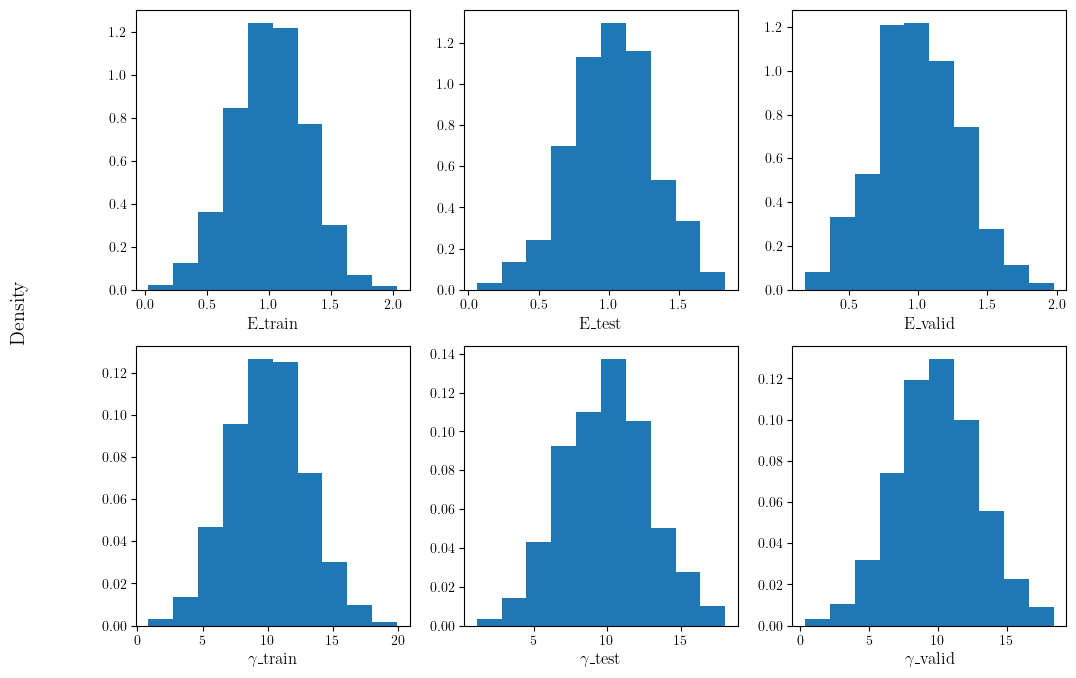

In [128]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
dens = True
if dens:
    fig.supylabel('Density')
else:
    fig.supylabel('Frequency')
    
xlabel_list_jkr = ['E_train', 'E_test', 'E_valid',
                  '$\gamma$_train', '$\gamma$_test', '$\gamma$_valid']
for ix, sp in enumerate(ax.flat):
    sp.set_xlabel(xlabel_list_jkr[ix])

ax[0,0].hist(train_df_jkr['E_jkr'],10, density=dens)
ax[0,1].hist(test_df_jkr['E_jkr'], 10, density=dens)
ax[0,2].hist(valid_df_jkr['E_jkr'], 10, density=dens)
ax[1,0].hist(train_df_jkr['gamma_jkr'], 10, density=dens)
ax[1,1].hist(test_df_jkr['gamma_jkr'], 10, density=dens)
ax[1,2].hist(valid_df_jkr['gamma_jkr'], 10, density=dens)



### Defining inputs and labels for train_test_vali dataframes

df -> np.arrays

In [129]:
jkr_df_list = [train_df_jkr, test_df_jkr, valid_df_jkr]
ft_cols = ['withdraw_contact', 'f_jkr_contact']
lb_cols = ['E_jkr', 'gamma_jkr']
dataset_jkr_list = []

for _, df in enumerate(jkr_df_list):
    aux_arr_ft = np.array(df[ft_cols])
    dataset_jkr_list.append(aux_arr_ft)
    aux_arr_lb = np.array(df[lb_cols])
    dataset_jkr_list.append(aux_arr_lb)

x_train_jkr, y_train_jkr, x_test_jkr, y_test_jkr, x_valid_jkr, y_valid_jkr = dataset_jkr_list

x_train_jkr.shape, y_train_jkr.shape, x_test_jkr.shape, y_test_jkr.shape, x_valid_jkr.shape, y_valid_jkr.shape

((2520, 2), (2520, 2), (540, 2), (540, 2), (540, 2), (540, 2))

In [130]:
x_train_t_jkr = tensor_input_shape(x_train_jkr)
x_valid_t_jkr = tensor_input_shape(x_valid_jkr)
x_test_t_jkr = tensor_input_shape(x_test_jkr)
y_train_t_jkr = torch.from_numpy(y_train_jkr).type(torch.float)
y_valid_t_jkr = torch.from_numpy(y_valid_jkr).type(torch.float)
y_test_t_jkr = torch.from_numpy(y_test_jkr).type(torch.float)
#x_train_t2 = torch.from_numpy(x_train).type(torch.float)

x_train_t_jkr.shape, y_train_t_jkr.shape, y_valid_t_jkr.shape, y_test_t_jkr.shape

(torch.Size([2520, 20, 2]),
 torch.Size([2520, 2]),
 torch.Size([540, 2]),
 torch.Size([540, 2]))

In [131]:
class JKR_Dataset():
  
  def __init__(self,features,labels):
    self.features = features
    self.labels = labels
 
  def __len__(self):
    return len(self.labels)
   
  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [132]:
train_data_jkr = JKR_Dataset(x_train_t_jkr, y_train_t_jkr)
test_data_jkr = JKR_Dataset(x_test_t_jkr, y_test_t_jkr)
valid_data_jkr = JKR_Dataset(x_valid_t_jkr, y_valid_t_jkr)

In [133]:
################ After changing one of the hyperparameters: ########################
### Re-run the cells where the model class and the model_params dict are defined ###

# HYPERPARAMETERS
LEARNING_RATE_JKR = 0.001
EPOCHS_JKR = 100
BATCH_SIZE_JKR = 128

# Size of each layer
HIDDEN_UNITS_1_JKR = 512
HIDDEN_UNITS_2_JKR = 256

ARCHITECTURE_JKR = 1

In [134]:
train_loader_jkr=DataLoader(train_data_jkr,batch_size=BATCH_SIZE_JKR,shuffle=True)
test_loader_jkr=DataLoader(test_data_jkr,batch_size=int(test_ratio_jkr*size+1),shuffle=False)
valid_loader_jkr=DataLoader(valid_data_jkr, batch_size=int(valid_ratio_jkr*size+1), shuffle=False)

In [135]:
# Define the linear regression model
class Regression_JKR(nn.Module):
    def __init__(self, input_shape, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR):
        super(Regression_JKR, self).__init__()
        input_size = input_shape[0] * input_shape[1]
        self.layers = nn.Sequential(nn.Flatten(),
                                    nn.Linear(input_size, HIDDEN_UNITS_1_JKR),
                                    nn.ReLU(),
                                    nn.Linear(HIDDEN_UNITS_1_JKR,HIDDEN_UNITS_2_JKR),
                                    nn.ReLU(),
                                    nn.Linear(HIDDEN_UNITS_2_JKR,64),
                                    nn.ReLU(),
                                    nn.Linear(64, 2))
    def forward(self, x):
        out = self.layers(x)
        return out
# Define input shape
input_shape_jkr = x_train_t_jkr.shape[1:]

# Instantiate the model
torch.manual_seed(42)
model_jkr = Regression_JKR(input_shape_jkr, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR)

# Define the loss function and optimizer
# loss_fn_jkr = nn.MSELoss(reduction='none')
# loss_fn_jkr = nn.MSELoss()
loss_fn_jkr = nn.L1Loss(reduction='none')

optimizer_jkr = torch.optim.SGD(model_jkr.parameters(),
                                lr=LEARNING_RATE_JKR)

In [136]:
# Custom loss functions

class NMSELoss(nn.Module):
    def __init__(self):
        super(NMSELoss, self).__init__()
        # self.mse = nn.MSELoss()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, input, target):
        # Compute the mean squared error (MSE)
        mse = self.mse(input, target)

        # Compute the normalization factor
        # norm_factor = torch.mean(torch.square(target))
        norm_factor = torch.square(target)
        # norm_factor = target * input

        # Compute the normalized mean squared error (NMSE)
        # nmse = (mse / norm_factor)
        nmse = (mse / norm_factor).mean(dim=0)

        return nmse
    
criterion_jkr = NMSELoss()

In [137]:
model_params_jkr = {'Epochs': EPOCHS_JKR, 
                'Learning Rate': LEARNING_RATE_JKR,
                'Batch Size': BATCH_SIZE_JKR,
                'Number of Hidden layers': 2,
                'Type of layers': nn.Linear,
                'Activation function': nn.ReLU(),
                'Architecture': ARCHITECTURE_JKR,
                'Hidden Units 1': HIDDEN_UNITS_1_JKR,
                'Hidden Units 2': HIDDEN_UNITS_2_JKR,
                'Input shape': list(input_shape_jkr),
                'Loss function': loss_fn_jkr,
                'Optimizer': optimizer_jkr}
# model_params_jkr

In [138]:
def train_one_epoch_jkr(epoch_index, train_loader): # (epoch_index, tb_writer)
    # running_loss = 0.
    # last_loss = 0.
    loss_list = []
    error_E_list = []
    error_gamma_list = []
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer_jkr.zero_grad()
        predicts = model_jkr(inputs)
        # Compute the loss and its gradients
        '''max, _ = loss_fn_jkr(predicts, labels).max(0)
        loss = (loss_fn_jkr(predicts, labels)/max).mean()'''
        error_E, _ = error_fn(predicts[:,0].unsqueeze(dim=1), labels[:,0].unsqueeze(dim=1))
        error_gamma, _ = error_fn(predicts[:,1].unsqueeze(dim=1), labels[:,1].unsqueeze(dim=1))
        loss1, loss2 = loss_fn_jkr(predicts[:,0], labels[:,0]), loss_fn_jkr(predicts[:,1], labels[:,1])
        loss = loss1 * loss2
        loss.backward()
        # Adjust learning weights
        optimizer_jkr.step()
        # Gather data and report
        loss_list.append(loss.item())
        error_E_list.append(error_E)
        error_gamma_list.append(error_gamma)
        # running_loss += loss.item()  # .item() converts tensor to number
        # print(i, loss.item())
    return loss_list, error_E_list, error_gamma_list

In [139]:
def train_model_JKR(EPOCHS: int,
                      model_jkr,
                      train_loader,
                      valid_loader,
                      loss_fn_jkr,
                      optimizer_jkr,
                      x_test_t, y_test_t,
                      dataset_list: list
                      ):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Set new directory for new model
    initial_wd = os.getcwd()
    create_model_dir(timestamp, contact_model='jkr')

    best_vloss = 1e15
    cols = ['Epoch', 'Train Loss', 'Mean Train Loss', 'Mean Val Loss', 
            'E - Train Error (%)', 'E - Mean Train Error (%)', 'E - Mean Val Error (%)', 
            'gamma - Train Error (%)', 'gamma - Mean Train Error (%)', 'gamma - Mean Val Error (%)']
    row = []
    for epoch in range(EPOCHS):
        # print('EPOCH {}:'.format(epoch + 1))
        # Make sure gradient tracking is on, and do a pass over the data
        model_jkr.train(True)
        loss_list, error_E_list, error_gamma_list = train_one_epoch_jkr(epoch, train_loader) # (epoch, writer)
        # We don't need gradients on to do reporting
        model_jkr.train(False)
        running_vloss, running_verror_E, running_verror_gamma = 0.0, 0.0, 0.0
        verror_E_list, verror_gamma_list, fts_list, labels_list = [], [], [], []
        # Validation cycle
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            fts_list.append(vinputs)
            labels_list.append(vlabels)
            voutputs = model_jkr(vinputs)
            '''max, _ = loss_fn_jkr(voutputs, vlabels).max(0)
            vloss = (loss_fn_jkr(voutputs, vlabels)/max).mean()'''
            vloss1, vloss2 = loss_fn_jkr(voutputs[:,0], vlabels[:,0]), loss_fn_jkr(voutputs[:,1], vlabels[:,1])
            vloss = vloss1 * vloss2
            
            verror_E, verror_E_aux_list = error_fn(voutputs[:,0].unsqueeze(dim=1), vlabels[:,0].unsqueeze(dim=1))
            verror_gamma, verror_gamma_aux_list = error_fn(voutputs[:,1].unsqueeze(dim=1), vlabels[:,1].unsqueeze(dim=1))
            running_vloss += vloss
            running_verror_E += verror_E
            running_verror_gamma += verror_gamma
            verror_E_list += verror_E_aux_list
            verror_gamma_list += verror_gamma_aux_list
        avg_vloss = running_vloss / (i + 1)
        avg_verror_E = running_verror_E / (i + 1)
        avg_verror_gamma = running_verror_gamma / (i + 1)
        row.append(dict(zip(cols, 
                            [epoch+1, loss_list, np.array(loss_list).mean(), avg_vloss.item(), 
                            error_E_list, np.array(error_E_list).mean(), avg_verror_E,
                            error_gamma_list, np.array(error_gamma_list).mean(), avg_verror_gamma])))
        # Track best performance
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_state_dict_{}_{}.pt'.format(timestamp, epoch+1)
            #torch.save(model_Hertz.state_dict(), model_path)
            verror_E_list_best = verror_E_list
            verror_gamma_list_best = verror_gamma_list
            fts_list_best = fts_list
            labels_list_best = labels_list
    torch.save(model_jkr.state_dict(), model_path)
    model_params['Model Path'] = model_path
    df = pd.DataFrame(row)
    df.to_csv('loss_error.csv', index=False)
    '''plot_loss_curve(df['Epoch'].values.tolist(), df['Mean Train Loss'].values.tolist(), df['Mean Val Loss'].values.tolist(), loss=True)
    plot_loss_curve(df['Epoch'].values.tolist(), df['Mean Train Error (%)'].values.tolist(), df['Mean Val Error (%)'].values.tolist(), loss=False)
    plot_bad_curves(verror_list_best, fts_list_best, labels_list_best, test=False)
    plot_error_hist(verror_list_best, test=False)'''
    with open('model_params.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = model_params.keys())
        writer.writeheader()
        writer.writerow(model_params)
    torch.save(x_test_t, 'x_test_t.pt')
    torch.save(y_test_t, 'y_test_t.pt')
    data_as_pkl(dataset_list)
    os.chdir(initial_wd)

In [140]:
# train_model_JKR(EPOCHS_JKR, model_jkr, train_loader_jkr, valid_loader_jkr, loss_fn_jkr, optimizer_jkr, x_test_t_jkr, y_test_t_jkr, dataset_jkr_list)

In [141]:
loss_epoch, error_E_epoch, error_gamma_epoch = [], [], []
for i in range(1):
    loss_list = []
    error_E_list = []
    error_gamma_list = []
    for i, data in enumerate(train_loader_jkr):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer_jkr.zero_grad()
        predicts = model_jkr(inputs)
        # Compute the loss and its gradients
        # loss = loss_fn_jkr(predicts, labels).mean(dim=0)
        # loss = criterion_jkr(predicts, labels)
        # For MAE:
        loss = loss_fn_jkr(predicts, labels)
        loss = loss/labels
        loss = loss.mean(dim=0)
        '''if i == 0:
            max_loss, _ = loss_fn_jkr(predicts, labels).max(0)
            max_loss = max_loss.detach()
        loss = (loss_fn_jkr(predicts, labels)/max_loss).mean()'''
        '''loss1, loss2 = loss_fn_jkr(predicts[:,0], labels[:,0]), loss_fn_jkr(predicts[:,1], labels[:,1])
        loss = loss1 + 100*loss2'''
        '''loss1, loss2 = loss_fn_jkr(predicts[:,0], labels[:,0]), loss_fn_jkr(predicts[:,1], labels[:,1])
        loss = loss1 * loss2'''
        # media Loss_E, 
        error_E, _ = error_fn(predicts[:,0].unsqueeze(dim=1), labels[:,0].unsqueeze(dim=1))
        error_gamma, _ = error_fn(predicts[:,1].unsqueeze(dim=1), labels[:,1].unsqueeze(dim=1))
        loss.backward(gradient=torch.tensor([1., 1.]))
        # loss.backward()
        # Adjust learning weights
        optimizer_jkr.step()
        # Gather data and report
        # loss_list.append(loss.item())
        loss_list.append(loss)
        error_E_list.append(error_E)
        error_gamma_list.append(error_gamma)
        # running_loss += loss.item()  # .item() converts tensor to number
        # print(i, loss.item())'''
    loss_epoch.append(sum(loss_list)/len(loss_list))
    error_E_epoch.append(sum(error_E_list)/len(error_E_list))
    error_gamma_epoch.append(sum(error_gamma_list)/len(error_gamma_list))
    # overall_loss_list.append(sum(loss_list)/len(loss_list))
    # overall_error_E_list.append(sum(error_E_list)/len(error_E_list))
    # overall_error_gamma_list.append(sum(error_gamma_list)/len(error_gamma_list))

In [142]:
predicts[:8, :], labels[:8, :]

(tensor([[ 1.0541,  7.3144],
         [ 1.0223, 10.7037],
         [ 0.9252,  8.9381],
         [ 0.8543,  6.6787],
         [ 0.9162, 12.8655],
         [ 1.2575, 18.1030],
         [ 0.8153, 10.4280],
         [ 0.6995,  9.8057]], grad_fn=<SliceBackward0>),
 tensor([[ 1.1807,  7.2154],
         [ 1.3317, 10.5278],
         [ 1.1734,  8.7824],
         [ 0.9141,  6.5998],
         [ 1.0928, 12.4645],
         [ 1.4712, 16.8975],
         [ 0.8397, 10.8805],
         [ 0.9506,  9.4394]]))

In [148]:
error_E, error_gamma, loss_epoch[0], loss_epoch[-1]

(16.43970489501953,
 3.7059850692749023,
 tensor([0.3854, 0.9060], grad_fn=<DivBackward0>),
 tensor([0.1662, 0.0383], grad_fn=<DivBackward0>))

In [144]:
loss_epoch[0], loss_epoch[-1]

(tensor([0.3854, 0.9060], grad_fn=<DivBackward0>),
 tensor([0.1662, 0.0383], grad_fn=<DivBackward0>))

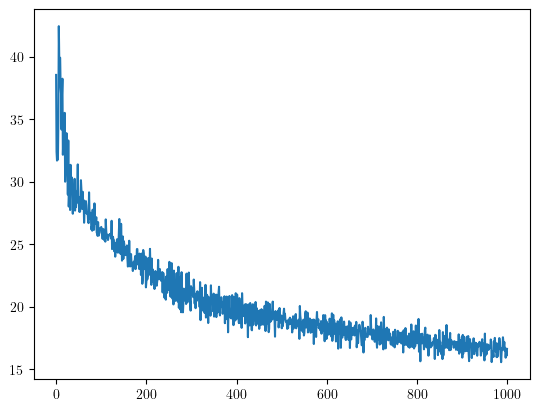

In [145]:
plt.plot(error_E_epoch)

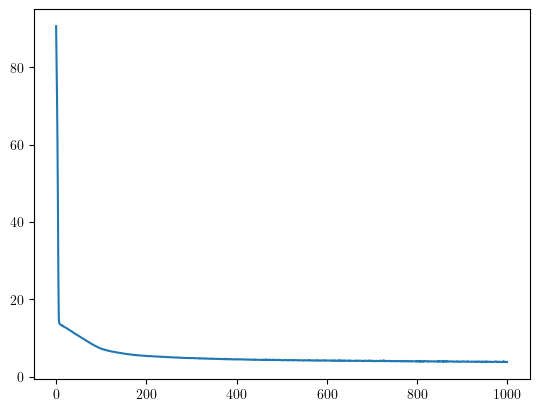

In [146]:
plt.plot(error_gamma_epoch)

In [147]:
loss_epoch

[tensor([0.3854, 0.9060], grad_fn=<DivBackward0>),
 tensor([0.3240, 0.8222], grad_fn=<DivBackward0>),
 tensor([0.3169, 0.7251], grad_fn=<DivBackward0>),
 tensor([0.3195, 0.6065], grad_fn=<DivBackward0>),
 tensor([0.3177, 0.4539], grad_fn=<DivBackward0>),
 tensor([0.3483, 0.2589], grad_fn=<DivBackward0>),
 tensor([0.4245, 0.1506], grad_fn=<DivBackward0>),
 tensor([0.3971, 0.1387], grad_fn=<DivBackward0>),
 tensor([0.3989, 0.1365], grad_fn=<DivBackward0>),
 tensor([0.3992, 0.1354], grad_fn=<DivBackward0>),
 tensor([0.3753, 0.1344], grad_fn=<DivBackward0>),
 tensor([0.3703, 0.1337], grad_fn=<DivBackward0>),
 tensor([0.3418, 0.1333], grad_fn=<DivBackward0>),
 tensor([0.3702, 0.1321], grad_fn=<DivBackward0>),
 tensor([0.3824, 0.1325], grad_fn=<DivBackward0>),
 tensor([0.3216, 0.1312], grad_fn=<DivBackward0>),
 tensor([0.3341, 0.1307], grad_fn=<DivBackward0>),
 tensor([0.3224, 0.1291], grad_fn=<DivBackward0>),
 tensor([0.3232, 0.1289], grad_fn=<DivBackward0>),
 tensor([0.3551, 0.1285], grad_